In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

# importing all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords
# from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

import time
from tqdm import tqdm
import string

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from scripts.processing import *

In [2]:
# load the review file into a dataframe

dfr = pd.read_csv('../data/yelp_dataset/review_1819.csv')

In [3]:
# filter for only english reviews

dfr = language_processing(dfr, verbose=True)

In our Dataset we have a total of 1 different languages,
classified with an accuracy of at least 0.95.
------------------------------------------------------------------------------------------------------------------------------------------------------
These languages are (unsorted): 
{'Vietnamese', 'Japanese', 'Portuguese', 'German', 'Turkish', 'Dutch', 'Spanish', 'Swedish', 'Italian', 'Hungarian', 'Chinese', 'French', 'English', 'Danish'}
------------------------------------------------------------------------------------------------------------------------------------------------------
The classified languages represent 88.96 % of the dataset
------------------------------------------------------------------------------------------------------------------------------------------------------
The most occurring language is English, it occurred 1612316 times
--------------------------------------------------------------------------------------------------------------------------------

In [4]:
dfr = dfr.iloc[:200000]

In [5]:
# initialize the stopword list:
stopwords = nltk.corpus.stopwords.words('english')

# update the stopwords after generating the first few clouds with non decisive words
#additional_stopwords = ['one', 'go', 'also', 'would', 'get', 'got']
#stopwords.extend(additional_stopwords)

In [6]:
# remove punctuation from the text in the initial df
# dfr['text'] = dfr['text'].apply(remove_punctuation)
dfr['text'] = dfr['text'].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

In [7]:
# split data into train and test set
train_set, test_set = train_test_split(pd.concat([dfr['text'], dfr['stars']], axis=1), random_state=RSEED) # concat…

In [8]:
# building mostly on (and partly copied from) https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
# documentation: https://radimrehurek.com/gensim/models/doc2vec.html
def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for token in nltk.word_tokenize(sent):
            tokens.append(token)
    return tokens

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    # targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents]) # TODO check importance of "steps" argument
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [22]:
# d2v = Doc2Vec.load('../models/doc2vec_100.model')
d2v = Doc2Vec.load('../models/doc2vec_500_small_5epochs.model')

In [23]:
train_tagged = train_set.apply(lambda r: TaggedDocument(words=tokenize(r.text), tags=[r.stars]), axis=1)
y_train, X_train = vec_for_learning(d2v, train_tagged)

test_tagged = test_set.apply(lambda r: TaggedDocument(words=tokenize(r.text), tags=[r.stars]), axis=1)
y_test, X_test = vec_for_learning(d2v, test_tagged)

In [24]:
# 
# # initialize the Classifier
# MNB = MultinomialNB()
# 
# # fit the model
# MNB.fit(X_train, y_train)
# 
# # make predictions
# y_pred = MNB.predict(X_test)
# 
# # test the model
# sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')
# 
# # show the classification report
# print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.76      0.66      0.70      9646
         2.0       0.08      0.45      0.13       666
         3.0       0.16      0.47      0.24      1577
         4.0       0.23      0.47      0.31      4358
         5.0       0.95      0.68      0.80     33753

    accuracy                           0.65     50000
   macro avg       0.44      0.55      0.44     50000
weighted avg       0.81      0.65      0.71     50000



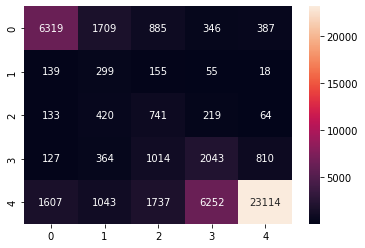

In [25]:
# initialize the Classifier
LSVC = LinearSVC()

# fit the model
LSVC.fit(X_train, y_train)

# make predictions
y_pred = LSVC.predict(X_test)

# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

# show the classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.77      0.66      0.71      9709
         2.0       0.15      0.43      0.22      1350
         3.0       0.25      0.43      0.31      2661
         4.0       0.29      0.47      0.36      5636
         5.0       0.91      0.72      0.81     30644

    accuracy                           0.66     50000
   macro avg       0.47      0.54      0.48     50000
weighted avg       0.76      0.66      0.70     50000



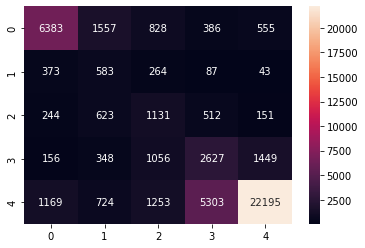

In [26]:
# initialize the Classifier
logreg = LogisticRegression()

# fit the model
logreg.fit(X_train, y_train)    

# make predictions
y_pred = logreg.predict(X_test)

# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

# show the classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.78      0.64      0.70     10121
         2.0       0.16      0.38      0.22      1561
         3.0       0.20      0.40      0.27      2301
         4.0       0.26      0.46      0.33      5089
         5.0       0.91      0.72      0.81     30928

    accuracy                           0.65     50000
   macro avg       0.46      0.52      0.47     50000
weighted avg       0.76      0.65      0.69     50000



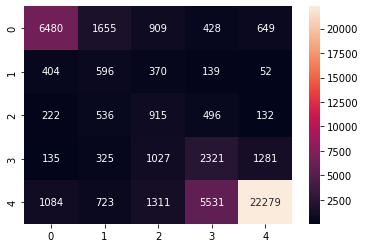

In [27]:
# initialize the Classifier
tree = RandomForestClassifier()

# fit the model
tree.fit(X_train, y_train)    

# make predictions
y_pred = tree.predict(X_test)

# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

# show the classification report
print(classification_report(y_pred, y_test))